In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import random
import numpy as np
from asyncio import exceptions

In [3]:
def pickle_load(dir, filename):
  # open a file, where you stored the pickled data
  file = open(os.path.join(dir,filename), 'rb')

  # dump information to that file
  data = pickle.load(file)

  # close the file
  file.close()
  return data

In [4]:
dir = '/content/drive/MyDrive/CVPR/Project/Pickle 2'
training_data_x = pickle_load(dir, "training_data_x.pk")[:200]
training_data_y = pickle_load(dir, "training_data_y.pk")[:200]

testing_data_x = pickle_load(dir, "testing_data_x.pk")[:40]
testing_data_y = pickle_load(dir, "testing_data_y.pk")[:40]

In [5]:
img_size = 256
categories = ['glioma', 'meningioma', 'no tumor', 'pituitary']

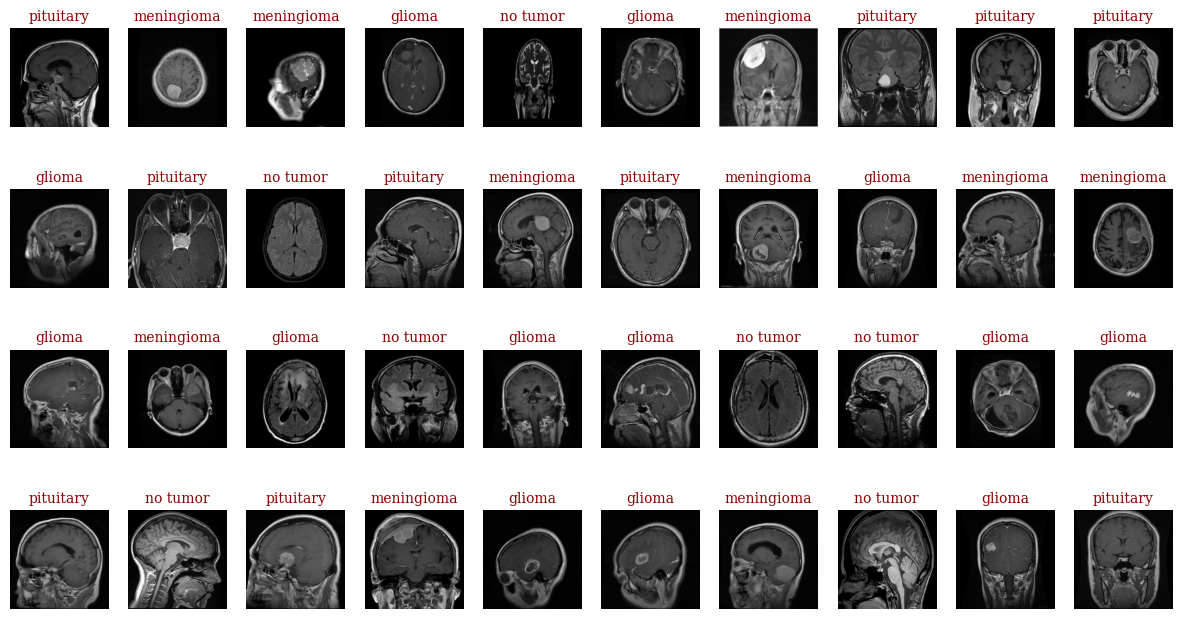

In [6]:
# Dataset 1
plt.figure(figsize=(15,8))
for i, img in enumerate(training_data_x) :
    plt.subplot(4,10, i+1)
    img = np.reshape(img, (img_size,img_size,3))
    plt.imshow(img)
    plt.axis('off')
    fontdict={'family': 'serif','color':  'darkred','weight': 'normal', 'size': 10,}
    category = categories[training_data_y[i]]
    plt.title(category, fontdict=fontdict)
    if (i+1) == 40:
        break
plt.show()

In [7]:
from tensorflow.keras.utils import to_categorical
training_data_y = to_categorical(training_data_y, 4)
testing_data_y = to_categorical(testing_data_y, 4)

In [8]:
print(training_data_x.shape, training_data_y.shape)
print(training_data_x.shape, training_data_y.shape)

(200, 256, 256, 3) (200, 4)
(200, 256, 256, 3) (200, 4)


In [9]:
from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Input, concatenate, Flatten, Dense, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model

In [10]:
cratched_model = Sequential([
    # Input(shape=(256, 256, 3)),
    layers.Conv2D(filters=112, kernel_size=(5,5),  activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(filters=80, kernel_size=(3,3), strides=(1,1),  activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1),  activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),  activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),  activation='relu'),

    # layers.Flatten(),
    # layers.Dense(units=768, activation='relu'),
    # layers.Dropout(0.5),
    # layers.Dense(units=4, activation='softmax')

])
# cratched_model.summary()

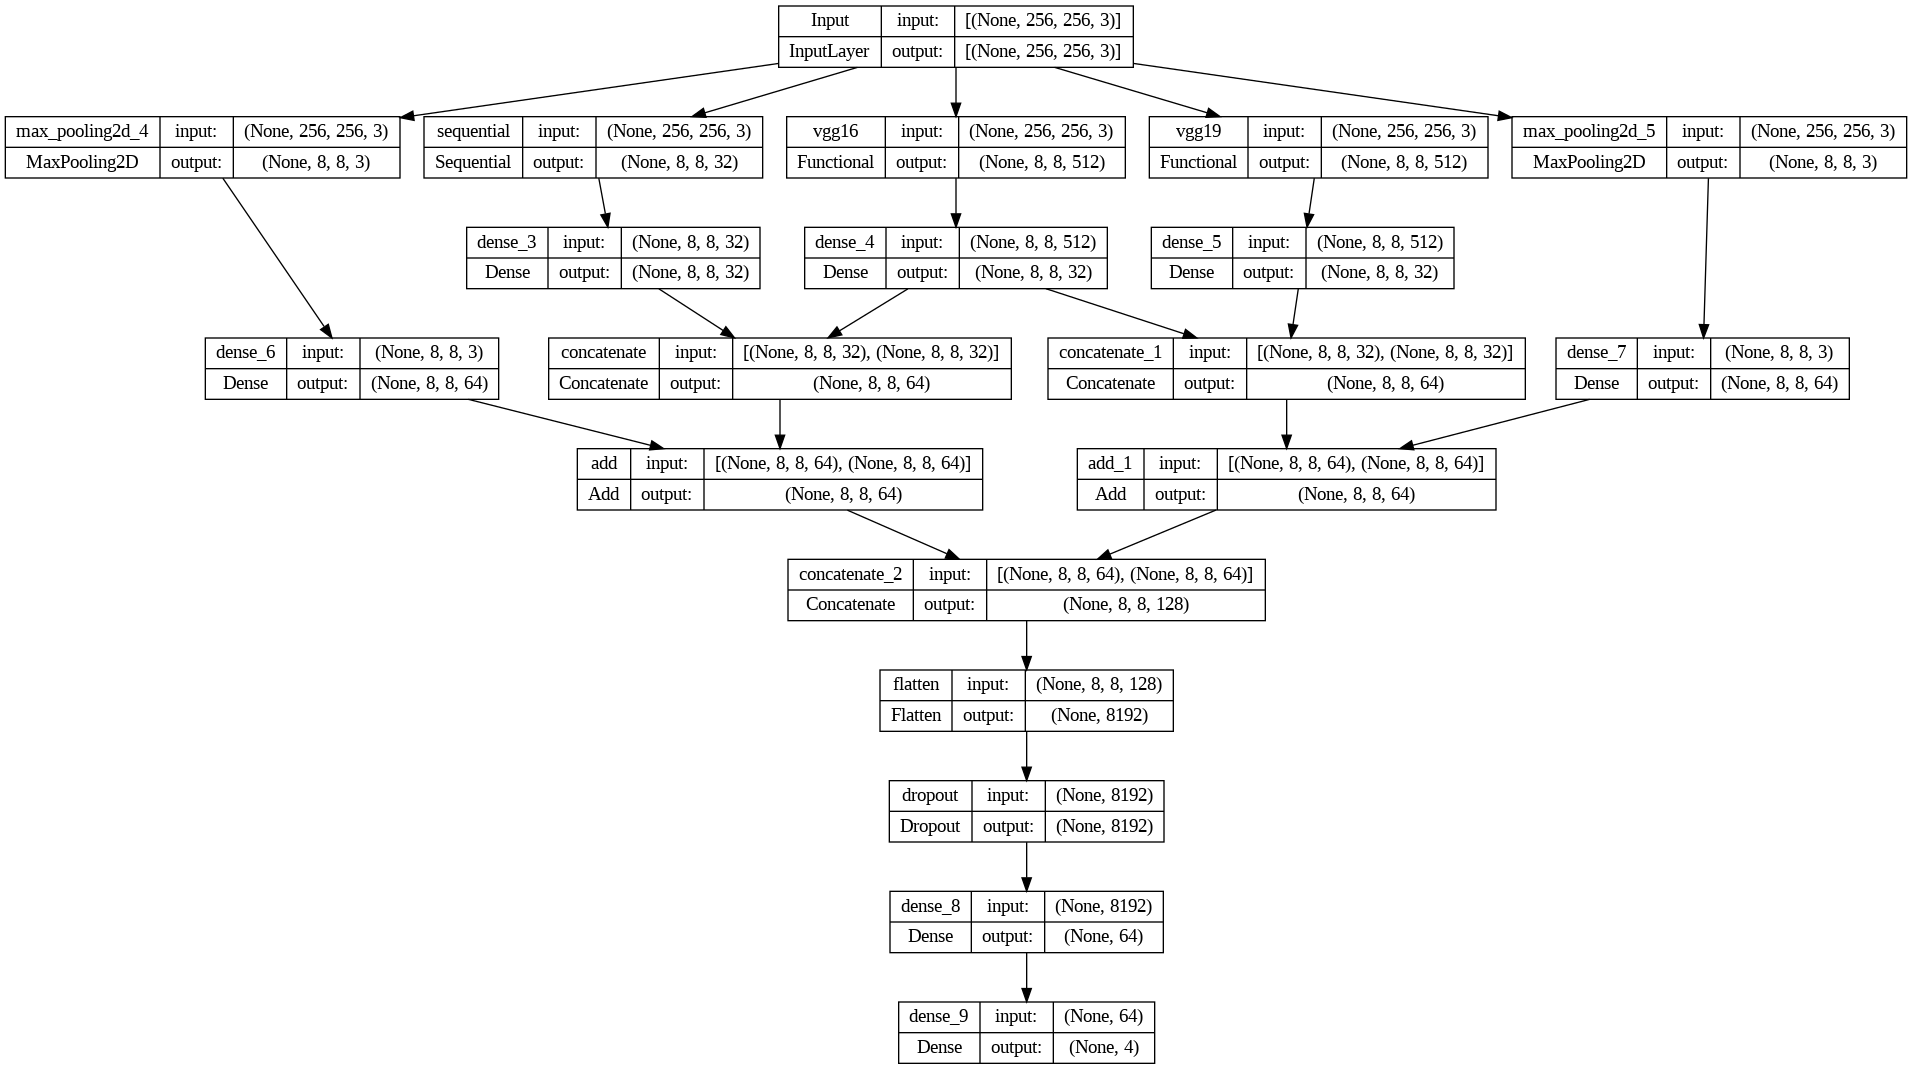

In [12]:
img_size = 256
ip_img = Input(shape=(img_size,img_size,3), name="Input")

# first ensemble

#Model 1
model1 = cratched_model(ip_img)

#Skipping connection 1
# skip_img1 = layers.MaxPooling2D(pool_size=(32,32), strides=(32,32))(ip_img)
# skip_dense1 = Dense(32, activation='relu')(skip_img1)
# skip_conn1 = Add()([model1, skip_dense1])

#Model 1 output
# model1_output = Dense(32, activation='relu')(skip_conn1)
model1_output = Dense(32, activation='relu')(model1)

#Model 2
model2 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))(ip_img)

#Skipping connection 2
# skip_img2 = layers.MaxPooling2D(pool_size=(32,32), strides=(32,32))(ip_img)
# skip_dense2 = Dense(512, activation='relu')(skip_img2)
# skip_conn2 = Add()([model2, skip_dense2])

#Model 2 output
model2_output = Dense(32, activation='relu')(model2)
# model2_output = Dense(32, activation='relu')(skip_conn2)


#Model 3
model3 = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))(ip_img)

#Skipping connection 3
# skip_img3 = layers.MaxPooling2D(pool_size=(32,32), strides=(32,32))(ip_img)
# skip_dense3 = Dense(512, activation='relu')(skip_img3)
# skip_conn3 = Add()([model3, skip_dense3])

#Model 3 output
model3_output = Dense(32, activation='relu')(model3)
# model3_output = Dense(32, activation='relu')(skip_conn3)


#Merging model 1 and 2
concat12 = concatenate([model1_output, model2_output])  # Merge dense1 and dense2

#Skipping connection 12
skip_img12 = layers.MaxPooling2D(pool_size=(32,32), strides=(32,32))(ip_img)
skip_dense12 = Dense(64, activation='relu')(skip_img12)
skip_conn12 = Add()([concat12, skip_dense12])


#Merging model 2 and 3
concat23 = concatenate([model2_output, model3_output])  # Merge dense1 and dense2

#Skipping connection 23
skip_img23 = layers.MaxPooling2D(pool_size=(32,32), strides=(32,32))(ip_img)
skip_dense23 = Dense(64, activation='relu')(skip_img23)
skip_conn23 = Add()([concat23, skip_dense23])


#Merging 12 and 23
concat12_23 = concatenate([skip_conn12, skip_conn23])  # Merge dense1 and dense2


#output
output = Flatten()(concat12_23)
output = Dropout(0.5)(output)
output = Dense(64, activation='relu')(output)
output = Dense(4, activation='softmax')(output)

# Create the model
model = Model(inputs=ip_img, outputs=output)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
hist = model.fit(x=training_data_x, y = training_data_y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
5/5 [==============================] - 1164s 233s/step - loss: 154.5639 - accuracy: 0.2500 - val_loss: 45.7476 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 1144s 234s/step - loss: 49.5866 - accuracy: 0.3812 - val_loss: 7.5502 - val_accuracy: 0.4000
Epoch 3/10
5/5 [==============================] - 1145s 233s/step - loss: 16.0316 - accuracy: 0.3875 - val_loss: 10.6761 - val_accuracy: 0.3750
Epoch 4/10
5/5 [==============================] - 1136s 230s/step - loss: 14.3261 - accuracy: 0.3375 - val_loss: 4.2936 - val_accuracy: 0.4000
Epoch 5/10
5/5 [==============================] - 1143s 233s/step - loss: 8.2731 - accuracy: 0.3375 - val_loss: 4.9390 - val_accuracy: 0.2750
Epoch 6/10
5/5 [==============================] - 1140s 233s/step - loss: 8.6843 - accuracy: 0.3688 - val_loss: 3.1827 - val_accuracy: 0.4250
Epoch 7/10
5/5 [==============================] - 1168s 239s/step - loss: 8.0115 - accuracy: 0.4313 - val_loss: 3.5230 - val_accuracy: 0.5250

In [15]:
results = model.evaluate(testing_data_x, testing_data_y, batch_size=128)
print("test loss, test acc:", results)

1/1 [==============================] - 83s 83s/step - loss: 1.3868 - accuracy: 0.2000
test loss, test acc: [1.386849045753479, 0.20000000298023224]


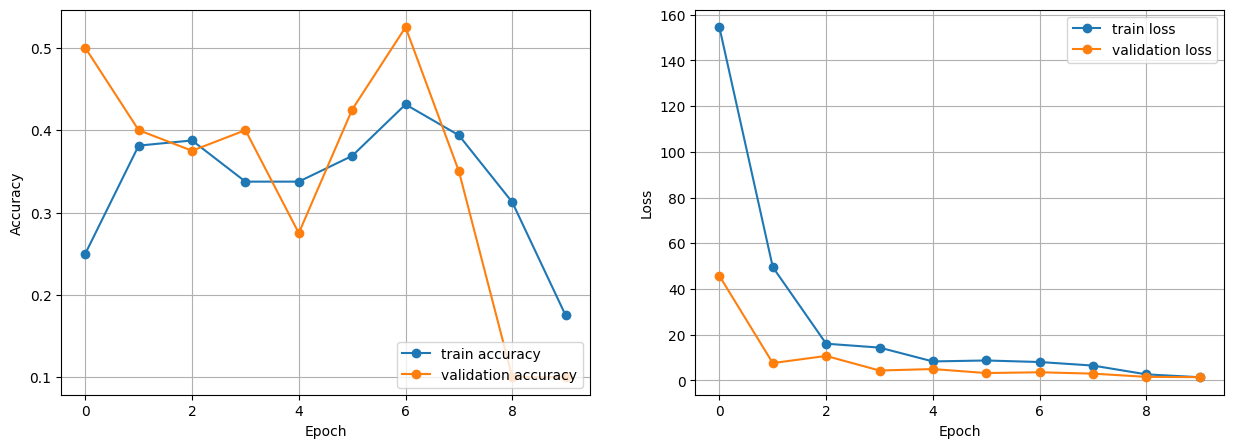

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], 'o-', label='train accuracy')
plt.plot(hist.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], 'o-', label='train loss')
plt.plot(hist.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [17]:
predictions = model.predict(testing_data_x)

2/2 [==============================] - 75s 14s/step


In [25]:
print(categories[np.argmax(testing_data_y[2])])

no tumor


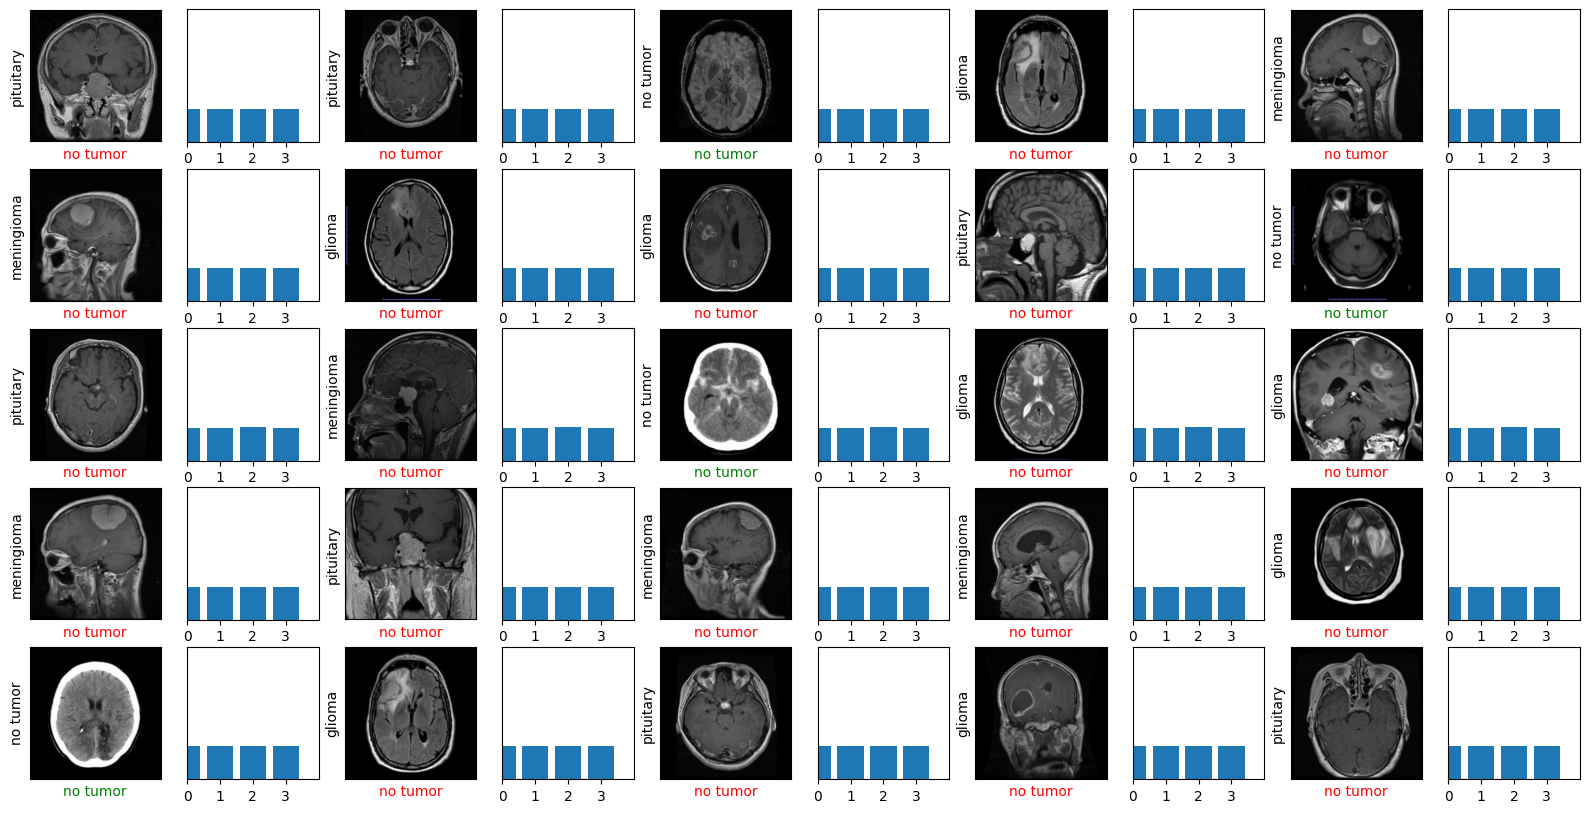

In [26]:
rows = 5
cols = 5

plt.figure(figsize=(20,10))
for i in range(25):

    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(testing_data_x[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(categories[np.argmax(testing_data_y[i])])
    c = np.argmax(predictions[i])
    # if testing_data_y[i][0] == np.argmax(predictions[i]):
    if testing_data_y[i][c] == 1:
        plt.xlabel(categories[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(categories[np.argmax(predictions[i])], color='r')


    plt.subplot(rows, 2*cols, 2*i+2)
    plt.bar(range(4), predictions[i])
    plt.yticks([])
    plt.xticks(range(0,4))
    plt.ylim([0,1])
    plt.xlim([0,4])

plt.show()